In [1]:
from datetime import datetime
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import joblib as jl

Using TensorFlow backend.


In [2]:
reviewContent = pd.read_table("../data/YelpZip/reviewContent",names=["user_id","name","date","review"])
df_review = pd.DataFrame(reviewContent)

metadata = pd.read_table("../data/YelpZip/metadata",names=["user_id", "prod_id", "rating", "label", "date"])
df_metadata = pd.DataFrame(metadata)

combine = pd.concat([df_review,df_metadata],axis=1,join="inner")#, join_axes=[df_reviewGraph.user_id])
combine = combine.dropna()

train = combine[["label","review"]] # add date later
train.head()

,label,review
0,-1,"Drinks were bad, the hot chocolate was watered..."
1,-1,This was the worst experience I've ever had a ...
2,-1,This is located on the site of the old Spruce ...
3,-1,I enjoyed coffee and breakfast twice at Toast ...
4,-1,I love Toast! The food choices are fantastic -...


In [3]:
# Make duplicates of negative samples to balance the data set
train1 = pd.concat([train[train["label"]==-1],train],axis=0)
train2 = pd.concat([train[train["label"]==-1],train1],axis=0)
train3 = pd.concat([train[train["label"]==-1],train2],axis=0)
balanced_train = pd.concat([train[train["label"]==-1],train3],axis=0)

# Convulotional Neural Networks

In [4]:
# a list contains each review as a list 
balanced_texts = []
balanced_labels = []

for i in range(len(train)):
    balanced_texts.append(train.iloc[i,1])
    balanced_labels.append(train.iloc[i,0])

In [5]:
# choose the first 20000 common words and set vector size as 500
tokenizer = Tokenizer(num_words=20000)#20000
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=500)#300

In [6]:
# build model and add layers
model = Sequential()
model.add(Embedding(20000, 128, input_length=500))#20000 300
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.array(balanced_labels), test_size=0.3)

In [8]:
# fit model
#model.fit(data, np.array(balanced_labels), validation_split=0.4, batch_size=200, epochs=3)
model.fit(X_train, y_train, batch_size=200, epochs=3)

Epoch 1/3
425920/425920 [==============================] - 1473s 3ms/step - loss: 0.5684 - acc: 0.8672
Epoch 2/3
425920/425920 [==============================] - 1841s 4ms/step - loss: 0.5458 - acc: 0.8570
Epoch 3/3
425920/425920 [==============================] - 1691s 4ms/step - loss: 0.4953 - acc: 0.7936


In [9]:
from sklearn.preprocessing import binarize

model_pred = model.predict(X_test)

In [10]:
class_pred = binarize(model_pred, threshold=0.5)

In [11]:
model.save("../../models/fake_review_cnn3_model.h5")

In [12]:
for i in range(len(class_pred)):
    if class_pred[i] == 0:
        class_pred[i] = -1

In [13]:
print("Report for CNN:")
print(classification_report(y_test, class_pred))

print("Accuracy for CNN:", accuracy_score(y_test, class_pred)*100)


Report for CNN models:
              precision    recall  f1-score   support

          -1       0.18      0.18      0.18     24070
           1       0.87      0.88      0.88    158468

   micro avg       0.78      0.78      0.78    182538
   macro avg       0.53      0.53      0.53    182538
weighted avg       0.78      0.78      0.78    182538

Accuracy for lr % : 78.30040868202785


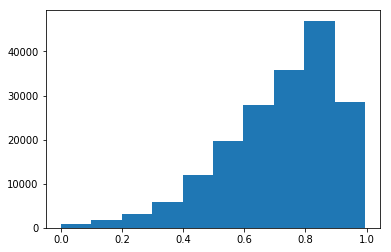

In [14]:
plt.hist(model_pred)
plt.show()

In [15]:
# Confusion matrix for CNN
print("Confusion Matrix for CNN: ")
confusion_matrix(y_test,class_pred)

Confusion Matrix for CNN: 


array([[  4246,  19824],
       [ 19786, 138682]], dtype=int64)

# Support Vector Machine

In [35]:
# a list contains each review as a list 
svc_texts = []
svc_labels = []

for i in range(len(balanced_train)):
    svc_texts.append(balanced_train.iloc[i,1])
    svc_labels.append(balanced_train.iloc[i,0])

In [36]:
# data preproccsing and fit Support Vector Machine
t1 = datetime.now()
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
svc_classifier = LinearSVC()
Xs = vectorizer.fit_transform(svc_texts)
 
print(datetime.now() - t1)
print(Xs.shape)
 
score = cross_val_score(svc_classifier, Xs,svc_labels, cv=2, n_jobs=-1)

print(datetime.now() - t1)
print(score)
print(sum(score) / len(score))

0:03:51.287015
(930302, 1832756)
0:09:45.887177
[0.81257094 0.80957756]
0.8110742500893378


In [37]:
# split data into training and testing sets
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, np.array(svc_labels), test_size=0.4)

In [41]:
svc_classifier.fit(Xs_train, ys_train)

svc_pred = svc_classifier.predict(Xs_test)

In [42]:
jl.dump(svc_classifier, '../../models/fake_review_svc_model.joblib')
jl.dump(vectorizer, "../../models/tfidf_vectorizer.joblib")

['tfidf_vectorizer.pickle']

In [44]:
print("Report for Support Vector Machine:")
print(classification_report(ys_test, svc_pred))

print("Accuracy for Support Vector Machine:", accuracy_score(ys_test, svc_pred)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

          -1       0.84      0.95      0.89    161016
           1       0.96      0.86      0.91    211105

   micro avg       0.90      0.90      0.90    372121
   macro avg       0.90      0.91      0.90    372121
weighted avg       0.91      0.90      0.90    372121

Accuracy for lr % : 89.99142751954338


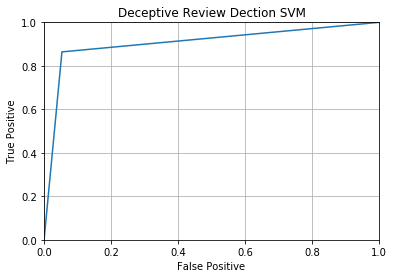

In [45]:
#draw ROC curve
fpr, tpr, thresholds = roc_curve(ys_test,svc_pred)

plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Deceptive Review Dection SVM")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


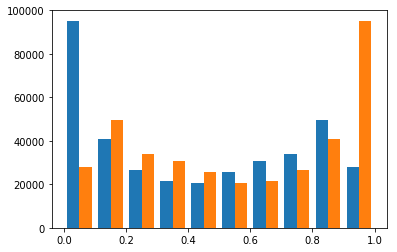

In [46]:
from sklearn.calibration import CalibratedClassifierCV

svc_to_proba = CalibratedClassifierCV(svc_classifier, cv=10)

svc_to_proba.fit(Xs_train, ys_train)

svc_proba = svc_to_proba.predict_proba(Xs_test)

#probability distribution of support vector machine prediction

plt.hist(svc_proba)

plt.show()

In [78]:
cal_svc_pred = binarize(np.array(svc_proba), threshold=0.5)
cal_svc_pred = np.array([1 if (x == [0, 1]).all() else -1 for x in cal_svc_pred])

print("Report for Calibrated Support Vector Machine:")
print(classification_report(ys_test, cal_svc_pred))

print("Accuracy for Calibrated Support Vector Machine:", accuracy_score(ys_test, cal_svc_pred)*100)

Report for Calibrated Support Vector Machine:
              precision    recall  f1-score   support

          -1       0.85      0.89      0.87    161016
           1       0.91      0.88      0.90    211105

   micro avg       0.89      0.89      0.89    372121
   macro avg       0.88      0.89      0.88    372121
weighted avg       0.89      0.89      0.89    372121

Accuracy for lr % : 88.62090556566278


In [47]:
#Confusion matrix for SVC before balance the data
print("Confusion Matric for SVC before balance the data: ")
confusion_matrix(ys_test, svc_pred)

Confusion Matric for SVC before balance the data: 


array([[152427,   8589],
       [ 28655, 182450]], dtype=int64)

In [80]:
#Confusion matrix for SVC after balance the data
print("Confusion Matric for SVC after balance the data: ")
confusion_matrix(ys_test, cal_svc_pred)

Confusion Matric for SVC after balance the data: 


array([[143163,  17853],
       [ 24491, 186614]], dtype=int64)